In [2]:
!pip install emoji

In [3]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.externals import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [0]:
df = pd.read_csv('/content/Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]

**EXPLORATORY DATA ANALYSIS**

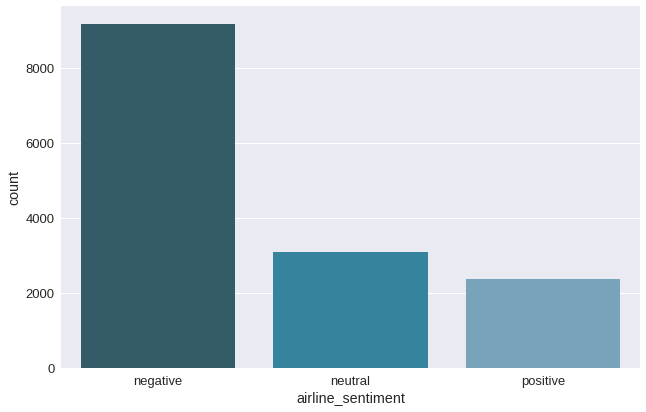

In [5]:
target_dist = sns.factorplot(x="airline_sentiment", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [0]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [0]:
tc = TextCounts()
df_eda = tc.transform(df.text)
# Add airline_sentiment to df_eda
df_eda['airline_sentiment'] = df.airline_sentiment

In [9]:
# debug
df_eda.head(5)

,count_capital_words,count_emojis,count_excl_quest_marks,count_hashtags,count_mentions,count_urls,count_words,airline_sentiment
10620,0,0,0,2,1,0,9,negative
13609,1,0,0,1,1,0,21,negative
2955,1,0,0,0,2,0,14,negative
3585,1,0,0,0,1,0,28,negative
2087,1,0,0,0,1,0,18,negative


In [0]:
#Descriptive stats for count_words
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', size=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
                    count       mean       std  min   25%   50%   75%   max
airline_sentiment                                                          
negative           9178.0  20.387557  6.100020  2.0  17.0  22.0  25.0  35.0
neutral            3099.0  15.290094  7.150738  2.0  10.0  15.0  21.0  34.0
positive           2363.0  14.478206  7.266129  2.0  8.0   14.0  21.0  33.0


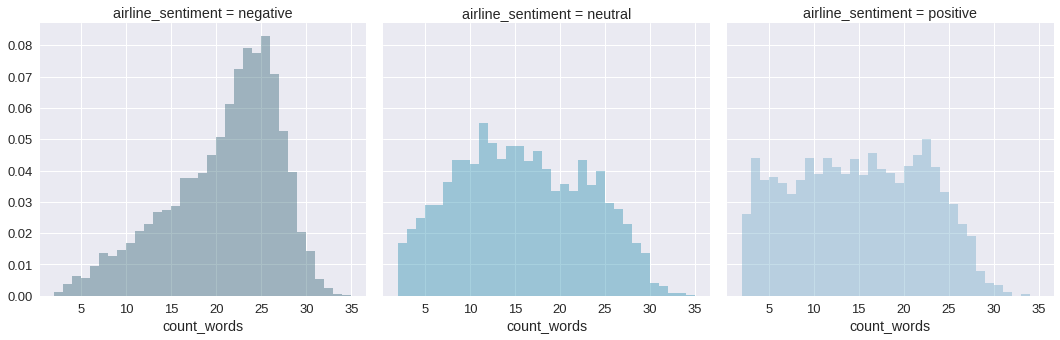

In [11]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_mentions
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  1.111244  0.365420  1.0  1.0  1.0  1.0  6.0
neutral            3099.0  1.167473  0.480102  1.0  1.0  1.0  1.0  5.0
positive           2363.0  1.138383  0.432462  1.0  1.0  1.0  1.0  6.0


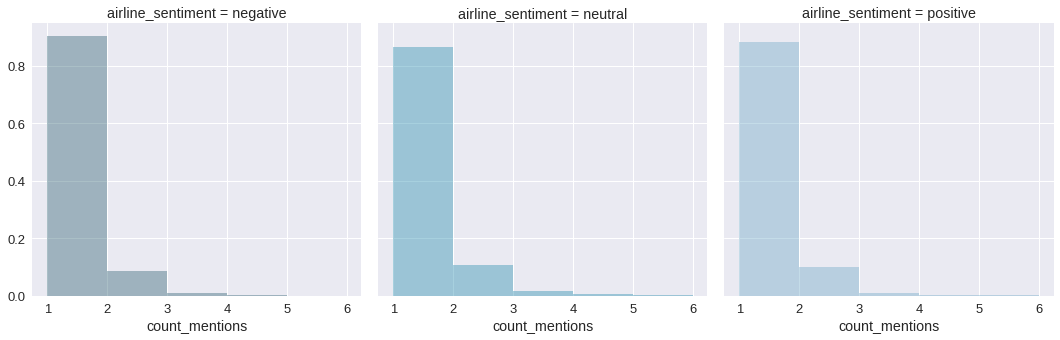

In [12]:
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  0.233384  0.615099  0.0  0.0  0.0  0.0  6.0
neutral            3099.0  0.212004  0.666382  0.0  0.0  0.0  0.0  6.0
positive           2363.0  0.297503  0.774776  0.0  0.0  0.0  0.0  8.0


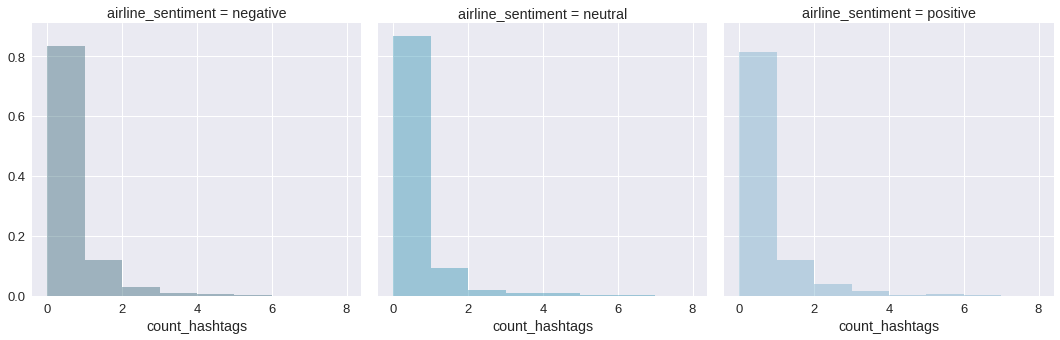

In [13]:
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.429070  1.019710  0.0  0.0  0.0  1.0  22.0
neutral            3099.0  0.462085  0.939468  0.0  0.0  0.0  1.0  11.0
positive           2363.0  0.461278  1.234078  0.0  0.0  0.0  1.0  20.0


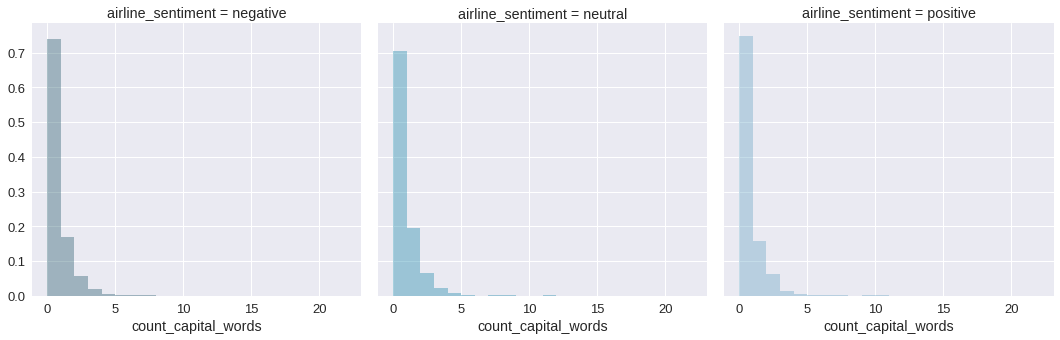

In [14]:
show_dist(df_eda, 'count_capital_words')

**DATA PREPROCESSING**

In [0]:
#TEXT CLEANING
class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [17]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
ct = CleanText()
sr_clean = ct.fit_transform(df.text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
# debug
sr_clean.head(5)

10620    told work joke fail                                                                
13609    aa usair elit member one big disappoint way treat epicfailur                       
2955     bummer might go card instead ty respons though                                     
3585     well incom flight dca take us ewr delay made us miss connect fll ye hotel necessari
2087     tri chang flight three time phone got disconnect time                              
Name: text, dtype: object

In [19]:
sr_clean.dropna()

10620    told work joke fail                                                                                  
13609    aa usair elit member one big disappoint way treat epicfailur                                         
2955     bummer might go card instead ty respons though                                                       
3585     well incom flight dca take us ewr delay made us miss connect fll ye hotel necessari                  
2087     tri chang flight three time phone got disconnect time                                                
12382    gate time though made cri made scene min instead board plane still outsid                            
4062     rd parti servic known eze flight man confirm born india told name steve wilson                       
3567     get clue mm miler respons give                                                                       
10064    worst custom servic ever                                                                             
1

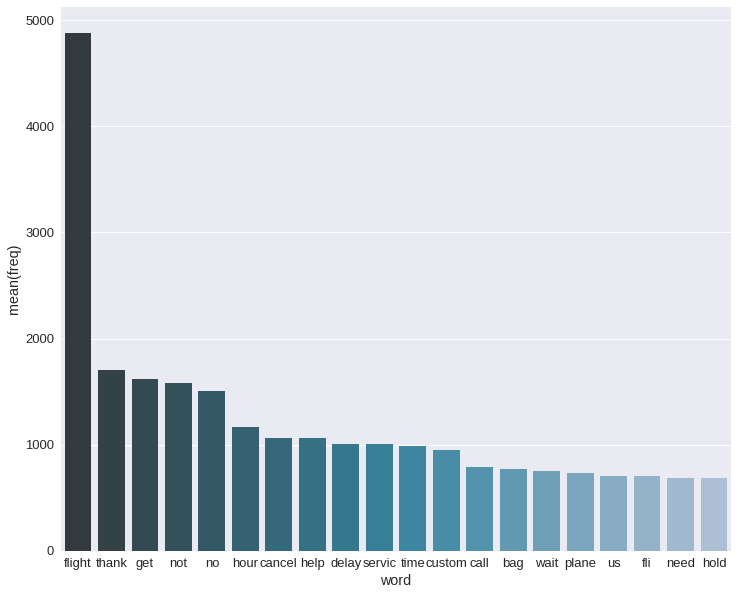

In [20]:
#most frequent words
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
#plot
fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [21]:
df_model = df_eda
df_model['clean_text'] = sr_clean
# df_model.columns.tolist()
df_model.head(10)

,count_capital_words,count_emojis,count_excl_quest_marks,count_hashtags,count_mentions,count_urls,count_words,airline_sentiment,clean_text
10620,0,0,0,2,1,0,9,negative,told work joke fail
13609,1,0,0,1,1,0,21,negative,aa usair elit member one big disappoint way treat epicfailur
2955,1,0,0,0,2,0,14,negative,bummer might go card instead ty respons though
3585,1,0,0,0,1,0,28,negative,well incom flight dca take us ewr delay made us miss connect fll ye hotel necessari
2087,1,0,0,0,1,0,18,negative,tri chang flight three time phone got disconnect time
12382,0,0,0,0,1,0,26,negative,gate time though made cri made scene min instead board plane still outsid
4062,1,0,0,0,1,0,25,neutral,rd parti servic known eze flight man confirm born india told name steve wilson
3567,0,0,1,0,1,0,17,negative,get clue mm miler respons give
10064,1,0,3,0,1,0,5,negative,worst custom servic ever
1809,0,0,1,1,1,0,20,negative,biz day calendar respond inquiri hope standard univers adopt badcustomerservic


In [0]:
X=df_model['clean_text']
y=df_model['airline_sentiment']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)

In [24]:
X_train.head(10)

1712     synonym rude cheap realli know valu custom                                               
11975    flight jacksonvil fl dalla show cancel flightl go rebook anoth flight                    
6919     chging flight isit possibl pay fare differ dollar ticket bought complet via point redempt
14030    add get go work tomorrow like wait late flightr cs suck                                  
1907     also inappropri lie passeng induc accept voucher tell avail late flightr                 
5796     know ❤️you tri patienc easier cheaper way tpa pdx stuck turn hr mci                      
14066                                                                                             
9484     reach hardwork mom tri best                                                              
3318     realli think downgrad booz food select club good way go look                             
1724     line baggag system complet rubbish bag miss day no meaning inform                        
Name: clea

In [25]:
y_train.head(10)

1712     negative
11975    negative
6919     neutral 
14030    negative
1907     negative
5796     negative
14066    neutral 
9484     negative
3318     negative
1724     negative
Name: airline_sentiment, dtype: object

**DBOW+Logistic Regression**

In [0]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

In [0]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result
all_x = pd.concat([X_train,X_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [28]:
all_x_w2v[0:5]

[LabeledSentence(words=['synonym', 'rude', 'cheap', 'realli', 'know', 'valu', 'custom'], tags=['all_1712']),
 LabeledSentence(words=['flight', 'jacksonvil', 'fl', 'dalla', 'show', 'cancel', 'flightl', 'go', 'rebook', 'anoth', 'flight'], tags=['all_11975']),
 LabeledSentence(words=['chging', 'flight', 'isit', 'possibl', 'pay', 'fare', 'differ', 'dollar', 'ticket', 'bought', 'complet', 'via', 'point', 'redempt'], tags=['all_6919']),
 LabeledSentence(words=['add', 'get', 'go', 'work', 'tomorrow', 'like', 'wait', 'late', 'flightr', 'cs', 'suck'], tags=['all_14030']),
 LabeledSentence(words=['also', 'inappropri', 'lie', 'passeng', 'induc', 'accept', 'voucher', 'tell', 'avail', 'late', 'flightr'], tags=['all_1907'])]

In [29]:
model_ug_dbow = Doc2Vec(dm=0, size=100, negative=1, min_count=1, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

100%|██████████| 14640/14640 [00:00<00:00, 1520104.23it/s]


In [30]:
%%time
for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha

100%|██████████| 14640/14640 [00:00<00:00, 2322676.95it/s]


CPU times: user 21.2 s, sys: 6.31 s, total: 27.5 s
Wall time: 21.6 s


In [0]:
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

In [0]:
#Calculating Vectors
train_vecs_dbow = get_vectors(model_ug_dbow, X_train, 100)
test_vecs_dbow = get_vectors(model_ug_dbow, X_test, 100)

In [0]:
trainvecnp=np.array(train_vecs_dbow)
testvecnp=np.array(test_vecs_dbow)
ytrain=pd.DataFrame(y_train)
ytest=pd.DataFrame(y_test)
enc = OneHotEncoder()
ytrain1=enc.fit_transform(ytrain).toarray()
le=LabelEncoder()
ytest1=le.fit_transform(ytest)


In [34]:
#LOGISTIC REGRESSION
import numpy 
def sigmoid(x):
    return 1. / (1 + numpy.exp(-x))

def softmax(x):
    e = numpy.exp(x - numpy.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / numpy.sum(e, axis=0)
    else:  
        return e / numpy.array([numpy.sum(e, axis=1)]).T  # ndim = 2


class LogisticRegression(object):
    def __init__(self, input, label, n_in, n_out):
        self.x = input
        self.y = label
        self.W = numpy.zeros((n_in, n_out))  # initialize W 0
        self.b = numpy.zeros(n_out)          # initialize bias 0

        # self.params = [self.W, self.b]

    def train(self, lr=0.1, input=None, L2_reg=0.00):
        if input is not None:
            self.x = input

        # p_y_given_x = sigmoid(numpy.dot(self.x, self.W) + self.b)
        p_y_given_x = softmax(numpy.dot(self.x, self.W) + self.b)
        d_y = self.y - p_y_given_x
        
        self.W += lr * numpy.dot(self.x.T, d_y) - lr * L2_reg * self.W
        self.b += lr * numpy.mean(d_y, axis=0)
        
        # cost = self.negative_log_likelihood()
        # return cost

    def negative_log_likelihood(self):
        # sigmoid_activation = sigmoid(numpy.dot(self.x, self.W) + self.b)
        sigmoid_activation = softmax(numpy.dot(self.x, self.W) + self.b)

        cross_entropy = - numpy.mean(
            numpy.sum(self.y * numpy.log(sigmoid_activation) +
            (1 - self.y) * numpy.log(1 - sigmoid_activation),
                      axis=1))

        return cross_entropy


    def predict(self, x):
        # return sigmoid(numpy.dot(x, self.W) + self.b)
        return softmax(numpy.dot(x, self.W) + self.b)


def test_lr(learning_rate=0.01, n_epochs=200):

    # construct LogisticRegression
    classifier = LogisticRegression(input=trainvecnp, label=ytrain1, n_in=100, n_out=3)

    # train
    for epoch in range(n_epochs):
        classifier.train(lr=learning_rate)
        cost = classifier.negative_log_likelihood()
#         print('Training epoch %d, cost is ' % epoch, cost)
        learning_rate *= 0.95


    # test
    y_pred=[]
    pred=classifier.predict(testvecnp)
    for p in pred:
      y_pred.append(np.argmax(p))
    print(classification_report(ytest1,y_pred,target_names=['negative','nuetral','positive']))
    print("Accuracy Score:",accuracy_score(ytest1,y_pred))


if __name__ == "__main__":
    test_lr()

              precision    recall  f1-score   support

    negative       0.77      0.84      0.80       911
     nuetral       0.48      0.33      0.39       320
    positive       0.56      0.62      0.59       233

   micro avg       0.69      0.69      0.69      1464
   macro avg       0.61      0.60      0.59      1464
weighted avg       0.67      0.69      0.68      1464

Accuracy Score: 0.6905737704918032


**Distributed Memory (concatenated) + Logistic Regression**



In [35]:
cores = multiprocessing.cpu_count()
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=1, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_w2v)])

100%|██████████| 14640/14640 [00:00<00:00, 1504019.66it/s]


In [36]:
%%time
for epoch in range(30):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmc.alpha -= 0.002
    model_ug_dmc.min_alpha = model_ug_dmc.alpha

100%|██████████| 14640/14640 [00:00<00:00, 1643284.46it/s]


CPU times: user 23.8 s, sys: 5.9 s, total: 29.7 s
Wall time: 21.7 s


In [0]:
train_vecs_dmc = get_vectors(model_ug_dmc, X_train, 100)
test_vecs_dmc = get_vectors(model_ug_dmc, X_test, 100)

In [0]:
trainvecnp=np.array(train_vecs_dmc)
testvecnp=np.array(test_vecs_dmc)
ytrain=pd.DataFrame(y_train)
ytest=pd.DataFrame(y_test)
enc = OneHotEncoder()
ytrain1=enc.fit_transform(ytrain).toarray()
le=LabelEncoder()
ytest1=le.fit_transform(ytest)


In [39]:
    #LOGISTIC REGRESSION
import numpy 
def sigmoid(x):
    return 1. / (1 + numpy.exp(-x))

def softmax(x):
    e = numpy.exp(x - numpy.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / numpy.sum(e, axis=0)
    else:  
        return e / numpy.array([numpy.sum(e, axis=1)]).T  # ndim = 2


class LogisticRegression(object):
    def __init__(self, input, label, n_in, n_out):
        self.x = input
        self.y = label
        self.W = numpy.zeros((n_in, n_out))  # initialize W 0
        self.b = numpy.zeros(n_out)          # initialize bias 0

        # self.params = [self.W, self.b]

    def train(self, lr=0.1, input=None, L2_reg=0.00):
        if input is not None:
            self.x = input

        # p_y_given_x = sigmoid(numpy.dot(self.x, self.W) + self.b)
        p_y_given_x = softmax(numpy.dot(self.x, self.W) + self.b)
        d_y = self.y - p_y_given_x
        
        self.W += lr * numpy.dot(self.x.T, d_y) - lr * L2_reg * self.W
        self.b += lr * numpy.mean(d_y, axis=0)
        
        # cost = self.negative_log_likelihood()
        # return cost

    def negative_log_likelihood(self):
        # sigmoid_activation = sigmoid(numpy.dot(self.x, self.W) + self.b)
        sigmoid_activation = softmax(numpy.dot(self.x, self.W) + self.b)

        cross_entropy = - numpy.mean(
            numpy.sum(self.y * numpy.log(sigmoid_activation) +
            (1 - self.y) * numpy.log(1 - sigmoid_activation),
                      axis=1))

        return cross_entropy


    def predict(self, x):
        # return sigmoid(numpy.dot(x, self.W) + self.b)
        return softmax(numpy.dot(x, self.W) + self.b)


def test_lr(learning_rate=0.01, n_epochs=200):

    # construct LogisticRegression
    classifier = LogisticRegression(input=trainvecnp, label=ytrain1, n_in=100, n_out=3)

    # train
    for epoch in range(n_epochs):
        classifier.train(lr=learning_rate)
        cost = classifier.negative_log_likelihood()
#         print('Training epoch %d, cost is ' % epoch, cost)
        learning_rate *= 0.95


    # test
    y_pred=[]
    pred=classifier.predict(testvecnp)
    for p in pred:
      y_pred.append(np.argmax(p))
    print(classification_report(ytest1,y_pred,target_names=['negative','nuetral','positive']))
    print("Accuracy Score:",accuracy_score(ytest1,y_pred))


if __name__ == "__main__":
    test_lr()


              precision    recall  f1-score   support

    negative       0.70      0.56      0.62       911
     nuetral       0.30      0.35      0.32       320
    positive       0.34      0.53      0.41       233

   micro avg       0.51      0.51      0.51      1464
   macro avg       0.45      0.48      0.45      1464
weighted avg       0.56      0.51      0.52      1464

Accuracy Score: 0.5088797814207651


**Distributed Memory (mean) + Logistic Regression**

In [40]:
cores = multiprocessing.cpu_count()
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])

100%|██████████| 14640/14640 [00:00<00:00, 1691074.62it/s]


In [41]:
%%time
for epoch in range(30):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha

100%|██████████| 14640/14640 [00:00<00:00, 1628683.11it/s]


CPU times: user 31 s, sys: 6.51 s, total: 37.5 s
Wall time: 25.2 s


In [0]:
train_vecs_dmm = get_vectors(model_ug_dmm, X_train, 100)
test_vecs_dmm = get_vectors(model_ug_dmm, X_test, 100)

In [0]:
trainvecnp=np.array(train_vecs_dmm)
testvecnp=np.array(test_vecs_dmm)
ytrain=pd.DataFrame(y_train)
ytest=pd.DataFrame(y_test)
enc = OneHotEncoder()
ytrain1=enc.fit_transform(ytrain).toarray()
le=LabelEncoder()
ytest1=le.fit_transform(ytest)


In [44]:
    #LOGISTIC REGRESSION
import numpy 
def sigmoid(x):
    return 1. / (1 + numpy.exp(-x))

def softmax(x):
    e = numpy.exp(x - numpy.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / numpy.sum(e, axis=0)
    else:  
        return e / numpy.array([numpy.sum(e, axis=1)]).T  # ndim = 2


class LogisticRegression(object):
    def __init__(self, input, label, n_in, n_out):
        self.x = input
        self.y = label
        self.W = numpy.zeros((n_in, n_out))  # initialize W 0
        self.b = numpy.zeros(n_out)          # initialize bias 0

        # self.params = [self.W, self.b]

    def train(self, lr=0.1, input=None, L2_reg=0.00):
        if input is not None:
            self.x = input

        # p_y_given_x = sigmoid(numpy.dot(self.x, self.W) + self.b)
        p_y_given_x = softmax(numpy.dot(self.x, self.W) + self.b)
        d_y = self.y - p_y_given_x
        
        self.W += lr * numpy.dot(self.x.T, d_y) - lr * L2_reg * self.W
        self.b += lr * numpy.mean(d_y, axis=0)
        
        # cost = self.negative_log_likelihood()
        # return cost

    def negative_log_likelihood(self):
        # sigmoid_activation = sigmoid(numpy.dot(self.x, self.W) + self.b)
        sigmoid_activation = softmax(numpy.dot(self.x, self.W) + self.b)

        cross_entropy = - numpy.mean(
            numpy.sum(self.y * numpy.log(sigmoid_activation) +
            (1 - self.y) * numpy.log(1 - sigmoid_activation),
                      axis=1))

        return cross_entropy


    def predict(self, x):
        # return sigmoid(numpy.dot(x, self.W) + self.b)
        return softmax(numpy.dot(x, self.W) + self.b)


def test_lr(learning_rate=0.01, n_epochs=200):

    # construct LogisticRegression
    classifier = LogisticRegression(input=trainvecnp, label=ytrain1, n_in=100, n_out=3)

    # train
    for epoch in range(n_epochs):
        classifier.train(lr=learning_rate)
        cost = classifier.negative_log_likelihood()
#         print('Training epoch %d, cost is ' % epoch, cost)
        learning_rate *= 0.95


    # test
    y_pred=[]
    pred=classifier.predict(testvecnp)
    for p in pred:
      y_pred.append(np.argmax(p))
    print(classification_report(ytest1,y_pred,target_names=['negative','nuetral','positive']))
    print("Accuracy Score:",accuracy_score(ytest1,y_pred))


if __name__ == "__main__":
    test_lr()


              precision    recall  f1-score   support

    negative       0.76      0.83      0.79       911
     nuetral       0.48      0.34      0.39       320
    positive       0.60      0.61      0.61       233

   micro avg       0.69      0.69      0.69      1464
   macro avg       0.61      0.59      0.60      1464
weighted avg       0.67      0.69      0.68      1464

Accuracy Score: 0.6892076502732241


**DBOW+DMC+Logistic Regression**

In [0]:
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [0]:
train_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, X_train, 200)
test_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, X_test, 200)

In [0]:
trainvecnp=np.array(train_vecs_dbow_dmc)
testvecnp=np.array(test_vecs_dbow_dmc)
ytrain=pd.DataFrame(y_train)
ytest=pd.DataFrame(y_test)
enc = OneHotEncoder()
ytrain1=enc.fit_transform(ytrain).toarray()
le=LabelEncoder()
ytest1=le.fit_transform(ytest)

In [48]:
    #LOGISTIC REGRESSION
import numpy 
def sigmoid(x):
    return 1. / (1 + numpy.exp(-x))

def softmax(x):
    e = numpy.exp(x - numpy.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / numpy.sum(e, axis=0)
    else:  
        return e / numpy.array([numpy.sum(e, axis=1)]).T  # ndim = 2


class LogisticRegression(object):
    def __init__(self, input, label, n_in, n_out):
        self.x = input
        self.y = label
        self.W = numpy.zeros((n_in, n_out))  # initialize W 0
        self.b = numpy.zeros(n_out)          # initialize bias 0

        # self.params = [self.W, self.b]

    def train(self, lr=0.1, input=None, L2_reg=0.00):
        if input is not None:
            self.x = input

        # p_y_given_x = sigmoid(numpy.dot(self.x, self.W) + self.b)
        p_y_given_x = softmax(numpy.dot(self.x, self.W) + self.b)
        d_y = self.y - p_y_given_x
        
        self.W += lr * numpy.dot(self.x.T, d_y) - lr * L2_reg * self.W
        self.b += lr * numpy.mean(d_y, axis=0)
        
        # cost = self.negative_log_likelihood()
        # return cost

    def negative_log_likelihood(self):
        # sigmoid_activation = sigmoid(numpy.dot(self.x, self.W) + self.b)
        sigmoid_activation = softmax(numpy.dot(self.x, self.W) + self.b)

        cross_entropy = - numpy.mean(
            numpy.sum(self.y * numpy.log(sigmoid_activation) +
            (1 - self.y) * numpy.log(1 - sigmoid_activation),
                      axis=1))

        return cross_entropy


    def predict(self, x):
        # return sigmoid(numpy.dot(x, self.W) + self.b)
        return softmax(numpy.dot(x, self.W) + self.b)


def test_lr(learning_rate=0.01, n_epochs=200):

    # construct LogisticRegression
    classifier = LogisticRegression(input=trainvecnp, label=ytrain1, n_in=200, n_out=3)

    # train
    for epoch in range(n_epochs):
        classifier.train(lr=learning_rate)
        cost = classifier.negative_log_likelihood()
#         print('Training epoch %d, cost is ' % epoch, cost)
        learning_rate *= 0.95


    # test
    y_pred=[]
    pred=classifier.predict(testvecnp)
    for p in pred:
      y_pred.append(np.argmax(p))
    print(classification_report(ytest1,y_pred,target_names=['negative','nuetral','positive']))
    print("Accuracy Score:",accuracy_score(ytest1,y_pred))


if __name__ == "__main__":
    test_lr()


              precision    recall  f1-score   support

    negative       0.77      0.87      0.82       911
     nuetral       0.51      0.33      0.40       320
    positive       0.62      0.61      0.61       233

   micro avg       0.71      0.71      0.71      1464
   macro avg       0.63      0.60      0.61      1464
weighted avg       0.69      0.71      0.69      1464

Accuracy Score: 0.7103825136612022


**DBOW+DMM+Logistic Regression**

In [0]:
train_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, X_train, 200)
test_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, X_test, 200)

In [0]:
trainvecnp=np.array(train_vecs_dbow_dmm)
testvecnp=np.array(test_vecs_dbow_dmm)
ytrain=pd.DataFrame(y_train)
ytest=pd.DataFrame(y_test)
enc = OneHotEncoder()
ytrain1=enc.fit_transform(ytrain).toarray()
le=LabelEncoder()
ytest1=le.fit_transform(ytest)


In [61]:
#LOGISTIC REGRESSION
import numpy 
def sigmoid(x):
    return 1. / (1 + numpy.exp(-x))

def softmax(x):
    e = numpy.exp(x - numpy.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / numpy.sum(e, axis=0)
    else:  
        return e / numpy.array([numpy.sum(e, axis=1)]).T  # ndim = 2


class LogisticRegression(object):
    def __init__(self, input, label, n_in, n_out):
        self.x = input
        self.y = label
        self.W = numpy.zeros((n_in, n_out))  # initialize W 0
        self.b = numpy.zeros(n_out)          # initialize bias 0

        # self.params = [self.W, self.b]

    def train(self, lr=0.1, input=None, L2_reg=0.01):
        if input is not None:
            self.x = input

        # p_y_given_x = sigmoid(numpy.dot(self.x, self.W) + self.b)
        p_y_given_x = softmax(numpy.dot(self.x, self.W) + self.b)
        d_y = self.y - p_y_given_x
        
        self.W += lr * numpy.dot(self.x.T, d_y) - lr * L2_reg * self.W
        self.b += lr * numpy.mean(d_y, axis=0)
        
        # cost = self.negative_log_likelihood()
        # return cost

    def negative_log_likelihood(self):
        # sigmoid_activation = sigmoid(numpy.dot(self.x, self.W) + self.b)
        sigmoid_activation = softmax(numpy.dot(self.x, self.W) + self.b)

        cross_entropy = - numpy.mean(
            numpy.sum(self.y * numpy.log(sigmoid_activation) +
            (1 - self.y) * numpy.log(1 - sigmoid_activation),
                      axis=1))

        return cross_entropy


    def predict(self, x):
        # return sigmoid(numpy.dot(x, self.W) + self.b)
        return softmax(numpy.dot(x, self.W) + self.b)


def test_lr(learning_rate=0.001, n_epochs=200):

    # construct LogisticRegression
    classifier = LogisticRegression(input=trainvecnp, label=ytrain1, n_in=200, n_out=3)

    # train
    for epoch in range(n_epochs):
        classifier.train(lr=learning_rate)
        cost = classifier.negative_log_likelihood()
#         print('Training epoch %d, cost is ' % epoch, cost)
        learning_rate *= 0.95


    # test
    y_pred=[]
    pred=classifier.predict(testvecnp)
    for p in pred:
      y_pred.append(np.argmax(p))
    print(classification_report(ytest1,y_pred,target_names=['negative','nuetral','positive']))
    print("Accuracy Score:",accuracy_score(ytest1,y_pred))


if __name__ == "__main__":
    test_lr()

              precision    recall  f1-score   support

    negative       0.77      0.91      0.84       911
     nuetral       0.62      0.36      0.45       320
    positive       0.69      0.62      0.65       233

   micro avg       0.74      0.74      0.74      1464
   macro avg       0.69      0.63      0.65      1464
weighted avg       0.73      0.74      0.72      1464

Accuracy Score: 0.7418032786885246
